In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../")

In [65]:
from torchganime.models.vqgan import VQGAN
from torchganime.models.ganime import GANime, GANimeConfig
import torch
import matplotlib.pyplot as plt
from torchganime.data.dataloader.video import VideoData
from torchvision.utils import make_grid

In [4]:
vqgan = VQGAN.load_from_checkpoint("/TorchGANime/checkpoints/vqgan_full/checkpoints/epoch=199-step=168800.ckpt")

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

loaded pretrained LPIPS loss from /TorchGANime/torchganime/models/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [48]:
dataloader = VideoData("../../data/kny/raw_videos/02.mkv", "../../data/snk/raw_videos/02.mkv", image_size=(128, 256), batch_size=8, num_workers=16)

2023-01-01 15:18:53.805 | INFO     | torchganime.data.dataset.video:_get_video_paths:365 - Found 1 videos
2023-01-01 15:18:54.289 | INFO     | torchganime.data.dataset.video:_get_video_paths:365 - Found 1 videos


In [71]:
first_frames = []
i = 0
for b in dataloader.train_dataloader():
    first_frames.append(b["first_frame"])
    frame_number = b["frame_number"]
    if i >= 30:
        break
    i += 1

In [72]:
frame_number

tensor([16, 17, 22, 19, 17, 15, 24, 15])

In [75]:
frame_number - 5

tensor([11, 12, 17, 14, 12, 10, 19, 10])

In [50]:
first_frames = torch.cat(first_frames, dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


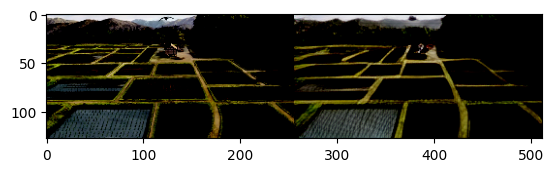

In [63]:
img_idx = 7
output = vqgan(first_frames[img_idx:img_idx+1])[0]
concat = torch.cat([first_frames[img_idx], output[0]], dim=-1)
plt.imshow(concat.permute(1, 2, 0).detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


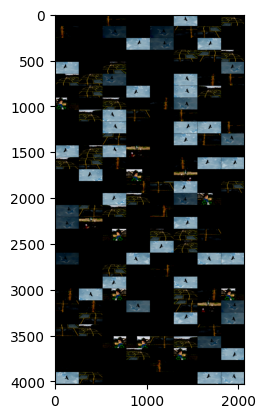

In [62]:

plt.imshow(make_grid(first_frames).permute(1, 2, 0).detach().numpy())

In [110]:
from transformers import GPT2Config
ganime = GANime(GANimeConfig("/TorchGANime/checkpoints/vqgan_full/checkpoints/epoch=199-step=168800.ckpt", GPT2Config(), transformer_ckpt_path="gpt2-medium"))

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from /TorchGANime/torchganime/models/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [160]:

for b in dataloader.train_dataloader():
    output = ganime(b)
    break


In [155]:

import torch.nn.functional as F
@torch.no_grad()
def encode(frame):
    quant_z, _, info = ganime.vqgan.encode(frame)
    indices = info[2].view(quant_z.shape[0], -1)
    return quant_z, indices

@torch.no_grad()
def decode_to_img(index, zshape):
    bhwc = (zshape[0], zshape[2], zshape[3], zshape[1])
    quant_z = ganime.vqgan.quantize.get_codebook_entry(index.reshape(-1), shape=bhwc)
    x = ganime.vqgan.decode(quant_z)
    return x

def predict_next_indices(previous_frames_indices, end_frames_indices):
    input = torch.cat((previous_frames_indices, end_frames_indices), dim=1)
    logits = ganime.transformer(input).logits
    # cut off conditioning
    logits = logits[:, end_frames_indices.shape[1] :]
    probs = F.softmax(logits, dim=-1)
    _, ix = torch.topk(probs, k=1, dim=-1)
    # cut off conditioning
    # ix = ix[:, end_frames_indices.shape[1] :]
    ix = torch.squeeze(ix)
    return ix, logits

def predict(
     first_frames, end_frames, frame_number: torch.tensor, target=None
) -> dict:
    frame_number.max()
    first_frames_quant, first_frames_indices = encode(first_frames)
    _, end_frames_indices = encode(end_frames)

    generated_frames_indices = [first_frames_indices]
    predicted_logits = []
    for i in range(1, 2):  # frame_number.max()):
        remaining_frames = frame_number - i

        next_frame_indices, logits = predict_next_indices(
            generated_frames_indices[-1], end_frames_indices
        )
        predicted_logits.append(logits)
        generated_frames_indices.append(next_frame_indices)

    generated_video = [
        decode_to_img(frame_indices, first_frames_quant.shape)
        for frame_indices in generated_frames_indices
    ]
    generated_video = torch.stack(generated_video, dim=2)

    if target is not None:
        loss = 0
        for i in range(len(predicted_logits)):
            target_quant, _, target_info = ganime.vqgan.encode(target[:, :, i])
            target_indices = target_info[2]#.view(target_quant.shape[0], -1)
            logits = predicted_logits[i]#.reshape(-1, predicted_logits[i].size(-1))
            logits = logits.permute(0, 2, 1)
            target = target_indices.reshape(logits.shape[0], -1)
            # print(logits.shape, target.shape)
            loss += F.cross_entropy(logits, target)

        return {"loss": loss, "logits": generated_video}
    return {"logits": generated_video}

In [156]:
output = predict(b["first_frame"], b["end_frame"], b["frame_number"], b["target"])

In [158]:
output["logits"].shape

torch.Size([8, 3, 2, 128, 256])

In [154]:
F.cross_entropy(logits.permute(0, 2, 1), target)

tensor(8.3411, grad_fn=<NllLoss2DBackward0>)

In [153]:
logits.permute(0, 2, 1).shape

torch.Size([8, 50257, 512])

In [152]:
target.shape

torch.Size([8, 512])

In [162]:
output["logits"].shape

torch.Size([8, 3, 5, 128, 256])